# Anomaly Detection

In [1]:
# Third-Party Packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
from sklearn.neighbors import LocalOutlierFactor
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Matplotlib Default Configuration
mpl.rc('axes', titlesize=8)
mpl.rc('grid', linestyle=':')
register_matplotlib_converters()

In [3]:
# Constants
FIG_WIDTH, FIG_HEIGHT = 11, 4

## Definitions

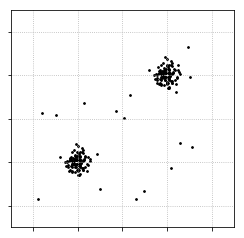

In [4]:
fig, ax = plt.subplots(figsize=(FIG_HEIGHT, FIG_HEIGHT))

np.random.seed(42)
X_inliers = 0.3 * np.random.randn(100, 2)
X_inliers = np.r_[X_inliers + 2, X_inliers - 2]
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))
X = np.r_[X_inliers, X_outliers]

ax.scatter(X[:, 0], X[:, 1], color='k', s=3.)

ax.set_xlim((-5, 5))
ax.set_ylim((-5, 5))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid()

plt.savefig('../slides/figures/anomalies.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

## Statistical-Based Anomaly Detection

In [5]:
data = pd.read_csv('../datasets/demos/taxi-passengers.csv')
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data.index = data['date']

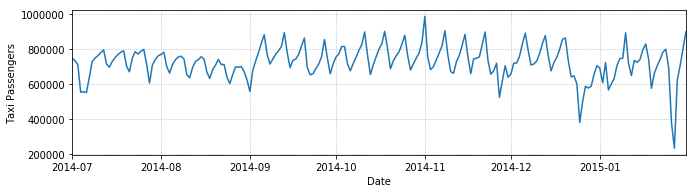

In [6]:
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT / 1.5))

ax.plot(data['date'], data['passengers'])

ax.set_xlabel('Date')
ax.set_ylabel('Taxi Passengers')
ax.set_xlim(data['date'].min(), data['date'].max())
ax.grid()

plt.savefig('../slides/figures/taxi-passengers-visualization.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

### Moving Average/Low Pass Filter

In [7]:
data['mean3d'] = data['passengers'].rolling(3).mean()
data['mean5d'] = data['passengers'].rolling(5).mean()
data['mean10d'] = data['passengers'].rolling(10).mean()
data['mean20d'] = data['passengers'].rolling(20).mean()
data['std20dmean'] = data['passengers'].rolling(20).std()

In [8]:
%%writefile ../slides/snippets/taxi-passengers-low-pass-1.py
# Data Import
data = pd.read_csv(
    'https://raw.githubusercontent.com/saschaschworm/big-data-and-data-science/'
    'master/datasets/demos/taxi-passengers.csv')

# Feature and Index Transformation
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data.index = data['date']

# 20-day Moving Average Calculation
data['mean20d'] = data['passengers'].rolling(20).mean()

# 20-day Moving Standard Deviation Calculation
data['std20dmean'] = data['passengers'].rolling(20).std()

Overwriting ../slides/snippets/taxi-passengers-low-pass-1.py


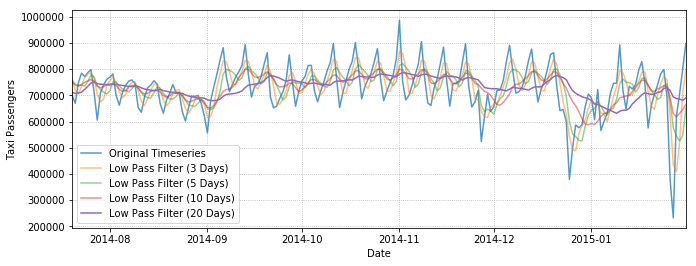

In [9]:
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT))

ax.plot(data['date'], data['passengers'], alpha=0.75, label='Original Timeseries')
ax.plot(data['date'], data['mean3d'], alpha=0.5, label='Low Pass Filter (3 Days)')
ax.plot(data['date'], data['mean5d'], alpha=0.5, label='Low Pass Filter (5 Days)')
ax.plot(data['date'], data['mean10d'], alpha=0.5, label='Low Pass Filter (10 Days)')
ax.plot(data['date'], data['mean20d'], label='Low Pass Filter (20 Days)')

ax.set_xlabel('Date')
ax.set_ylabel('Taxi Passengers')
ax.set_xlim(data['mean20d'].dropna().index.min(), data['mean20d'].dropna().index.max())
ax.grid()
ax.legend()

plt.savefig('../slides/figures/taxi-passengers-low-pass.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

In [10]:
upper_threshold = data['mean20d'] + 3 * data['std20dmean']
lower_threshold = data['mean20d'] - 3 * data['std20dmean']
anomalies = data[(data['passengers'] > upper_threshold) | (data['passengers'] < lower_threshold)]

In [11]:
anomalies['passengers']

date
2014-12-25    379302
2015-01-26    375311
2015-01-27    232058
Name: passengers, dtype: int64

In [12]:
%%writefile ../slides/snippets/taxi-passengers-low-pass-2.py
# Threshold Calculation with Three-Sigma Rule
upper_threshold = data['mean20d'] + 3 * data['std20dmean']
lower_threshold = data['mean20d'] - 3 * data['std20dmean']

# Anomaly Detection
anomalies = data[(data['passengers'] > upper_threshold) | 
                 (data['passengers'] < lower_threshold)]

# Output Anomalies
print(anomalies['passengers'])
> date
  2014-12-25    379302
  2015-01-26    375311
  2015-01-27    232058
  Name: passengers, dtype: int64

Overwriting ../slides/snippets/taxi-passengers-low-pass-2.py


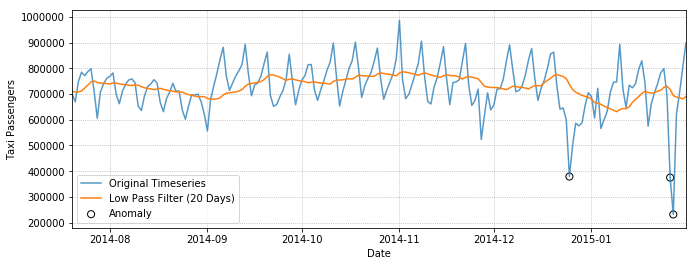

In [13]:
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT))

ax.plot(data['date'], data['passengers'],alpha=0.75, label='Original Timeseries')
ax.plot(data['date'], data['mean20d'], alpha=1, label='Low Pass Filter (20 Days)')
ax.scatter(anomalies['date'], anomalies['passengers'], facecolor='none', edgecolor='black', s=50, label='Anomaly')

ax.set_xlabel('Date')
ax.set_ylabel('Taxi Passengers')
ax.set_xlim(lower_threshold.dropna().index.min(), lower_threshold.dropna().index.max())
ax.grid()
ax.legend()

plt.savefig('../slides/figures/taxi-passengers-low-pass-result.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

### Seasonal and Trend Decomposition

In [14]:
data = pd.read_csv('../datasets/demos/air-passengers.csv')
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data.index = data['date']

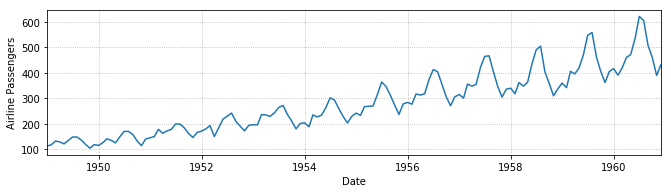

In [15]:
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT / 1.5))

ax.plot(data['date'], data['passengers'])

ax.set_xlabel('Date')
ax.set_ylabel('Airline Passengers')
ax.set_xlim(data['date'].min(), data['date'].max())
ax.grid()

plt.savefig('../slides/figures/airline-passengers-visualization.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

In [16]:
data['mean20d'] = data['passengers'].rolling(20).mean()
data['std20dmean'] = data['passengers'].rolling(20).std()

In [17]:
upper_threshold = data['mean20d'] + 2 * data['std20dmean']
lower_threshold = data['mean20d'] - 2 * data['std20dmean']
anomalies = data[(data['passengers'] > upper_threshold) | (data['passengers'] < lower_threshold)]

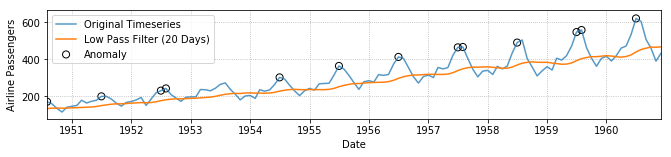

In [18]:
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT / 2))

ax.plot(data['date'], data['passengers'], alpha=0.75, label='Original Timeseries')
ax.plot(data['date'], data['mean20d'], label='Low Pass Filter (20 Days)')
ax.scatter(anomalies['date'], anomalies['passengers'], facecolor='none', edgecolor='black', s=50, label='Anomaly')

ax.set_xlabel('Date')
ax.set_ylabel('Airline Passengers')
ax.set_xlim(data['date'].min(), data['date'].max())
ax.set_xlim(data['mean20d'].dropna().index.min(), data['mean20d'].dropna().index.max())

ax.grid()
ax.legend()

plt.savefig('../slides/figures/airline-passengers-low-pass-anomalies.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

In [19]:
stl = seasonal_decompose(data['passengers'], 'multiplicative')
stl_resid_std = (stl.resid - np.mean(stl.resid)) / np.std(stl.resid)

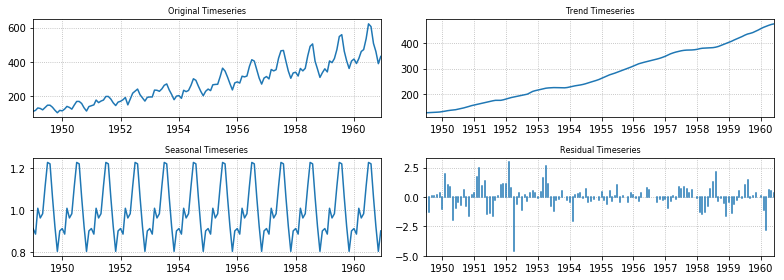

In [20]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(FIG_WIDTH, FIG_HEIGHT))

ax1.plot(data.index, data['passengers'])
ax1.set_title('Original Timeseries')
ax1.set_xlim(data.index.min(), data.index.max())
ax1.grid()

ax2.plot(stl.trend.index, stl.trend)
ax2.set_title('Trend Timeseries')
ax2.set_xlim(stl.trend.dropna().index.min(), stl.trend.dropna().index.max())
ax2.grid()

ax3.plot(stl.seasonal.index, stl.seasonal)
ax3.set_title('Seasonal Timeseries')
ax3.set_xlim(stl.seasonal.dropna().index.min(), stl.seasonal.dropna().index.max())
ax3.grid()

ax4.stem(stl.resid.index, stl_resid_std, markerfmt=' ', basefmt=' ')
ax4.set_title('Residual Timeseries')
ax4.set_xlim(stl.resid.dropna().index.min(), stl.resid.dropna().index.max())
ax4.grid()
fig.tight_layout()

plt.savefig('../slides/figures/airline-passengers-stl.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

In [21]:
data_beer = pd.read_csv('../datasets/demos/australian-beer.csv')
data_beer['Index'] = pd.to_datetime(data_beer['Index'], format='%Y')
data_beer = data_beer.iloc[:60, :]

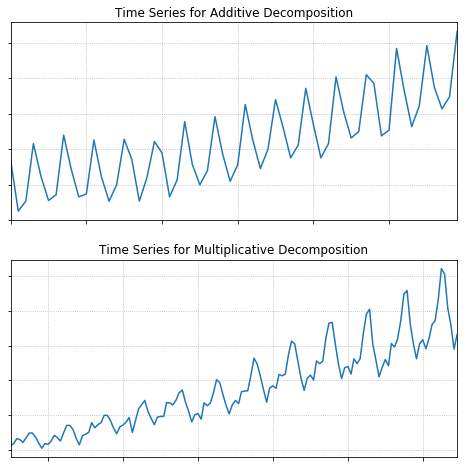

In [22]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

ax1.plot(data_beer.index, data_beer['x'])
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_xlim(data_beer.index.min(), data_beer.index.max())
ax1.set_title('Time Series for Additive Decomposition', fontsize=12)
ax1.grid()

ax2.plot(data['date'], data['passengers'])
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_xlim(data['date'].min(), data['date'].max())
ax2.set_title('Time Series for Multiplicative Decomposition', fontsize=12)
ax2.grid()

plt.savefig('../slides/figures/additive-multiplicative-decomposition.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

In [23]:
%%writefile ../slides/snippets/air-passengers-stl-1.py
# Additional Import Definitions
from statsmodels.tsa.seasonal import seasonal_decompose

# Data Import
data = pd.read_csv(
    'https://raw.githubusercontent.com/saschaschworm/big-data-and-data-science/'
    'master/datasets/demos/air-passengers.csv')

# Feature and Index Transformation
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data.index = data['date']

# Multiplicative Seasonal and Trend Decomposition
stl = seasonal_decompose(data['passengers'], 'multiplicative')

Overwriting ../slides/snippets/air-passengers-stl-1.py


In [24]:
# Lower and Upper Quantile Calculation
upper_threshold = np.quantile(stl.resid.dropna(), 0.99)
lower_threshold = np.quantile(stl.resid.dropna(), 0.01)

# Anomaly Detection
anomalies = data.loc[
    (stl.resid > upper_threshold) | 
    (stl.resid < lower_threshold), :]

# Output Anomalies
print(anomalies['passengers'])

date
1952-02-01    180
1952-04-01    150
1953-04-01    235
1960-03-01    419
Name: passengers, dtype: int64


In [25]:
%%writefile ../slides/snippets/air-passengers-stl-2.py
# Lower and Upper Quantile Calculation
upper_threshold = np.quantile(stl.resid.dropna(), 0.99)
lower_threshold = np.quantile(stl.resid.dropna(), 0.01)

# Anomaly Detection
anomalies = data.loc[
    (stl.resid > upper_threshold) | 
    (stl.resid < lower_threshold), :]

# Output Anomalies
print(anomalies['passengers'])
> date
  1952-02-01    180
  1952-04-01    150
  1953-04-01    235
  1960-03-01    419
  Name: passengers, dtype: int64

Overwriting ../slides/snippets/air-passengers-stl-2.py


In [26]:
upper_threshold = np.quantile(stl_resid_std.dropna(), 0.99)
lower_threshold = np.quantile(stl_resid_std.dropna(), 0.01)

res_anomalies = stl_resid_std[(stl_resid_std > upper_threshold) | (stl_resid_std < lower_threshold)]

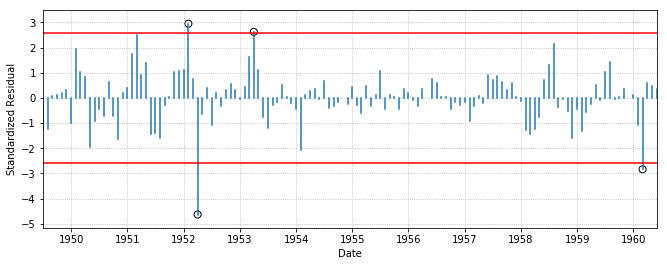

In [27]:
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT))

ax.stem(stl.resid.index, (stl.resid - np.mean(stl.resid)) / np.std(stl.resid), markerfmt=' ', basefmt=' ')
ax.axhline(upper_threshold, c='r')
ax.axhline(lower_threshold, c='r')
ax.scatter(res_anomalies.index, res_anomalies, facecolor='none', edgecolor='black', s=50, label='Anomaly')

ax.set_xlabel('Date')
ax.set_ylabel('Standardized Residual')
ax.set_xlim(stl.resid.dropna().index.min(), stl.resid.dropna().index.max())
ax.grid()

plt.savefig('../slides/figures/airline-passengers-stl-resid-anomalies.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

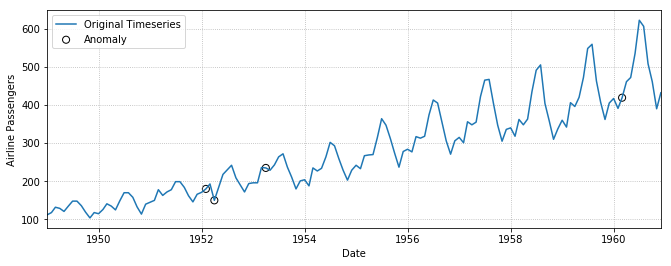

In [28]:
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT))

ax.plot(data['date'], data['passengers'], label='Original Timeseries')
ax.scatter(anomalies['date'], anomalies['passengers'], facecolor='none', edgecolor='black', s=50, label='Anomaly')

ax.set_xlabel('Date')
ax.set_ylabel('Airline Passengers')
ax.set_xlim(data['date'].min(), data['date'].max())
ax.grid()
ax.legend()

plt.savefig('../slides/figures/airline-passengers-stl-anomalies.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

## Density-Based Anomaly Detection

In [29]:
data = pd.read_csv('../datasets/demos/transactions.csv')
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data.index = data['date']

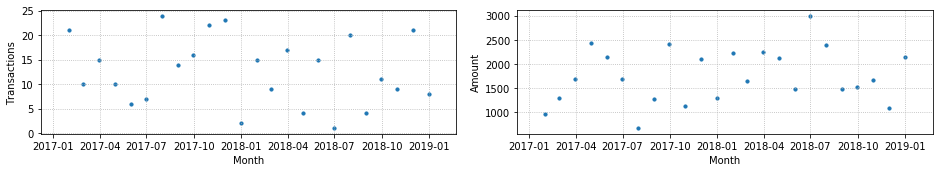

In [30]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(FIG_WIDTH * 1.2, 2.5))

ax1.scatter(data.index, data['transactions'], s=10)
ax1.set_xlabel('Month')
ax1.set_ylabel('Transactions')
ax1.grid()

ax2.scatter(data.index, data['amount'], s=10)
ax2.set_xlabel('Month')
ax2.set_ylabel('Amount')
ax2.grid()

plt.tight_layout()
plt.savefig('../slides/figures/lof-transactions.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

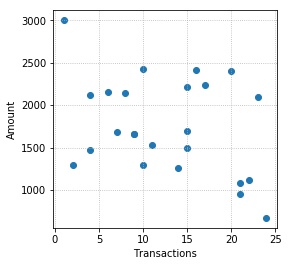

In [31]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(data['transactions'], data['amount'])
ax.set_xlabel('Transactions')
ax.set_ylabel('Amount')
ax.grid()

plt.savefig('../slides/figures/lof-transactions-combined.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

In [32]:
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto')
lof = lof.fit(data[['transactions', 'amount']])

In [33]:
%%writefile ../slides/snippets/transactions-lof.py
# Additional Import Definitions
from sklearn.neighbors import LocalOutlierFactor

# Data Import
data = pd.read_csv(
    'https://raw.githubusercontent.com/saschaschworm/big-data-and-data-science/'
    'master/datasets/demos/transactions.csv')

# Local Outlier Factor Initialization, Fitting and Scoring
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto')
prediction = lof.fit_predict(data[['transactions', 'amount']])
scores = lof.negative_outlier_factor_

# Output Anomalies
print(data[scores < -1.1])
>                  date  transactions  amount
  date                                       
  2017-07-31 2017-07-31            24     672
  2018-06-30 2018-06-30             1    3000

Overwriting ../slides/snippets/transactions-lof.py


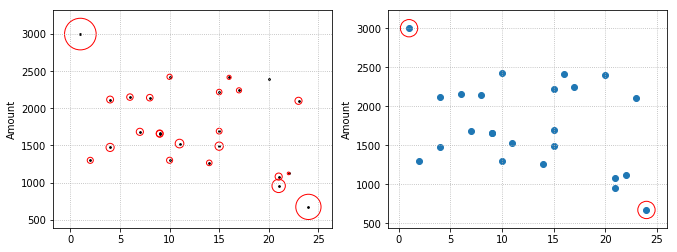

In [34]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(FIG_WIDTH, FIG_HEIGHT))

y_pred = lof.fit_predict(data[['transactions', 'amount']])
X_scores = lof.negative_outlier_factor_
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())

ax1.scatter(data['transactions'], data['amount'], color='k', s=3., label='Data points')
ax1.scatter(data['transactions'], data['amount'], s=1000 * radius, edgecolors='r', facecolors='none', label='Outlier scores')
ax1.set_ylabel('Transactions')
ax1.set_ylabel('Amount')
ax1.grid()

ax2.scatter(data['transactions'], data['amount'])
ax2.scatter(data[X_scores < -1.1]['transactions'], data[X_scores < -1.1]['amount'], s=300, edgecolors='r', facecolors='none', label='Outlier scores')
ax2.set_ylabel('Transactions')
ax2.set_ylabel('Amount')
ax2.grid()

plt.savefig('../slides/figures/lof-transactions-viz.pdf', transparent=True, bbox_inches='tight', pad_inches=0)